## Multiclass Classification
### First method: k-nearest neighbours (kNN)
### Second method: Naive Bayess
### Third method: Logistic Regression + Gradient Descent + Normal Equation
### Fourth method: Neural Network - 2 hidden layers, 25 nodes each

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import random
import time
import scipy.io

## Time Counting Method

In [2]:
def count_time(f, param_1, param_2, name):
    """
    This function counts how long does the given
    function work, and also it returns the results
    :param f: given function
    :param param_1, param_2: parameters for the given function
    :param name: Name of the functiob -> to display the time
    :return: results of given function
    """
    start = time.perf_counter()
    res = f(param_1, param_2)
    total = time.perf_counter() - start
    print(f"Time for: {name} => {total}s")
    return res

def count_time_silent(f, param_1, param_2):
    """
    This function also counts how long does
    the given function work, but it only returns the time
    :param f: given function
    :param param_1, param_2: parameters for the given function
    :return: value of time passed
    """
    start = time.perf_counter()
    _ = f(param_1, param_2)
    total = time.perf_counter() - start
    return total

## Data generatar

In [3]:
def standard_data_generator(N, noise):
    """
    Generates data for my plots - a little bit random
    with vissible class division
    :param N: number of examples in each class
    :param noise: value of noise for data randomizer
    :return: dictionary of numpy arrays for data_x1, data_x2 and labels
    """
    labels = np.array([[1]]*N + [[2]]*N + [[3]]*N + [[4]]*N)
    data = [random_data(1.5, noise, N), random_data(1.5, noise, N), 
            random_data(0.5, noise, N), random_data(1.5, noise, N),
            random_data(0.5, noise, N), random_data(0.5, noise, N),
            random_data(1.5, noise, N), random_data(0.5, noise, N)]
    conc_data_x1 = np.concatenate([d for d in data[::2]])
    conc_data_x2 = np.concatenate([d for d in data[1::2]])
    return {'x1': conc_data_x1, 'x2':conc_data_x2, 'y': labels}
    
    
def random_data(a, noise, N):
    """
    Generates random data in given range (noise)
    :param a: starting point for generator
    :param N: number of examples to generate
    :param noise: value of noise for data randomizer
    :return: numpy array
    """
    data = np.random.uniform(a - noise, a + noise, size = N)
    return np.array([[d] for d in data])


def totally_random_data_generator(N):
    """
    Generates totally random data in hardcoded range
    :param N: number of examples to generate
    :return: dictionary of numpy arrays
    """
    data_x1 = np.random.uniform(0.1, 1.9,size = N)
    data_x2 = np.random.uniform(0.1, 1.9,size = N)
    return {'x1': data_x1, 'x2': data_x2}


def advanced_theta_generator(n, mini, maxi):
    """
    Creates vector Theta with first values of parameters
    These values are random
    :param n: number of parameters
    :param mini, maxi: range for parameters randomizer
    :param value: default parameter value
    :return: vector nx1
    """
    return np.array([[random.uniform(mini,maxi)] for i in range(n)])

## Error Function

In [4]:
def error_function(distribution, y_labels):
    """
    Calculates error value for given distribution
    and given class labels
    :param distribution: given distribution
    :param y_labels: given class labels
    :return: error value - flaot
    """
    distribution = np.fliplr(distribution)
    maxs = np.argmax(distribution, axis=1)
    uniq = np.unique(y_labels).shape[0]
    res = np.count_nonzero(maxs != (uniq - y_labels.T))
    return res/y_labels.shape[0]

## k-Nearest Neighbours

In [5]:
def knn(train_data, val_data):
    """
    Starting method for k-Nearest Neighbours,
    it just separates data into single numpy arrays
    :param train_data: training data 
    :param val_data: validation data
    :return: results of knn_model_selection function
    """
    x1_train = train_data['x1']
    x2_train = train_data['x2']
    y_train = train_data['y']
    x1_val = val_data['x1']
    x2_val = val_data['x2']
    y_val = val_data['y']
    return knn_model_selection(x1_val, x2_val, y_val, x1_train, x2_train, y_train)


def knn_model_selection(x1_val, x2_val, y_val, x1_train, x2_train, y_train):
    """
    Firstly, it calculates distances between 
    val and training data sets, sorts them
    and chooses best k (best model). Finally
    predicted labels values are returned
    :param x1_val, x2_val, y_val: separated validation data 
    :param x1_train, x2_train, y_train: separated trasining data
    :return: minimal error, best k value, all errors,
    all k values, predicted labels for validation data
    """
    dists = calculate_distance(x1_val, x2_val, x1_train, x2_train)
    srt = sort_distances(dists, y_train)
    k_values = np.arange(1,x1_train.shape[0])
    error_list = list()
    labels_list = list()
    for k in k_values:
        distri, labels = calculate_distribution_knn(srt, k)
        error = error_function(distri, y_val)
        error_list.append(error)
        labels_list.append(labels)
    min_idx = error_list.index(min(error_list))
    return min(error_list), k_values[min_idx], error_list, k_values, labels_list[min_idx]


def calculate_distance(x1, x2, x1_train, x2_train):
    """
    Calculates Hamming distance between val and train data
    :param x1, x2: validation data 
    :param x1_train, x2_train: training data
    :return: numpy array of calculated distances
    """
    n1 = np.shape(x1)[0]
    n2 = np.shape(x1_train)[0]
    dists = np.array([((x1[v, 0] - x1_train)**2 + (x2[v, 0] - x2_train)**2)**(0.5) for v in range(n1)])    
    return dists[:,:,0]


def sort_distances(dists, y_labels):
    """
    Sorts y_labels respectively to sorted dists
    :param dists: distances 
    :param y_labels: class labels
    :return: sorted y_labels
    """
    return y_labels[dists.argsort(kind='mergesort')][:,:,0]


def calculate_distribution_knn(y_labels, k):
    """
    Calculates distribution for kNN
    :param y_labels: class labels 
    :param k: k value
    :return: calculated distribution and predicted labels
    """
    m = np.unique(y_labels).shape[0]
    distri = np.ones((y_labels.shape[0], m))
    for mi in range(m):
        buf = np.count_nonzero(y_labels[:,:k] == mi+1, axis=1)
        distri[:,mi] = buf
    distri = distri / np.sum(distri, axis=1).reshape((y_labels.shape[0],1))
    labels = np.argmax(distri, axis = 1)
    return distri, labels

## Naive Bayess - secret ingredient is gaussian distribution

$Y =  \begin{bmatrix}y^{(0)}\\y^{1)}\\...\\y^{(n-1)}\end{bmatrix}, X_{1} =  \begin{bmatrix}x^{(0)}_1\\x^{(1)}_1\\...\\x^{(n-1)}_1\end{bmatrix}, X_{2} =  \begin{bmatrix}x^{(0)}_2\\x^{(1)}_2\\...\\x^{(n-1)}_2\end{bmatrix}$

$\mu_{x,y} =  \frac{1}{n}  \sum_{i:y^{(i)} = y}^{} x^{(i)}_i$

$\sigma^2_{x,y} = \frac{1}{n} \sum_{i:y^{(i)} = y}(x^{(i)} -  \mu_{x,y})$

$p(x_j | y) = \frac{1}{\sqrt{2\pi \sigma^2_{x_j,y}}} \cdot exp-\frac{1}{2}(\frac{(x-\mu_{x_j,y})^2}{\sigma^2_{x_j,y}})$ for j = 0,...,n-1

In [6]:
def a_prioi(y):
    """
    Calculates probability of occurance of
    each value in given array
    :param y: given array 
    :return: array of probabilities
    """
    N = np.shape(y)[0]
    M = np.unique(y).shape[0]
    return np.array([(N - np.count_nonzero(y - i)) / N for i in range(1,M+1)])


def calculate_means(x1, x2, y, N_val):
    """
    Calculates the arithmetic mean 
    for each unique label
    :param x1, x2: given arrays with data_x
    :param y: given labels
    :param N_val: number of val examples
    :return: replicated array of means
    """
    N = np.shape(x1)[0]
    M = np.unique(y).shape[0]
    buf = [[np.mean(x1[np.nonzero(y == m+1)[0], :]), np.mean(x2[np.nonzero(y == m+1)[0], :])] for m in range(M)]
    res_single = np.array(buf).T    
    return np.tile(res_single, N_val).reshape((2,N_val,M))


def calculate_variance(x1, x2, y, N_val):
    """
    Calculates the variance 
    for each unique label
    :param x1, x2: given arrays with data_x
    :param y: given labels
    :param N_val: number of val examples
    :return: replicated array of variances
    """
    N = np.shape(x1)[0]
    M = np.unique(y).shape[0]
    buf = [[np.var(x1[np.nonzero(y == m+1)[0], :]), np.var(x2[np.nonzero(y == m+1)[0], :])] for m in range(M)]
    res_single = np.array(buf).T    
    return np.tile(res_single, N_val).reshape((2,N_val,M))


def gauss(x1, x2, mean, var):
    """
    Calculates gauss distribution
    :param x1, x2: given arrays with data_x
    :param mean: calculated means
    :param var: calculated variances
    :return: array with gauss distribution
    """
    x = np.concatenate((x1, x2), axis=1).T
    _, N, M = np.shape(mean)
    distribution = np.ones((2,N,M))
    for m in range(M):
        fst_prt = 1 / (2*math.pi*var[:,:,m])**(0.5)
        powerr = -0.5*((x - mean[:,:,m])**2 / var[:,:,m])
        snd_prt = np.power(math.e, powerr)
        together = fst_prt*snd_prt
        distribution[:,:,m] = together
    return distribution


def p_x_y_nb(guass_distribution):
    """
    Calculates product of gauss distribution
    :param guass_distribution: given arrays with distribution
    :return: array with product
    """
    return np.prod(guass_distribution,axis=0).T


def calculate_distribution_nb(apriori, p_x_y):
    """
    Calculates distribution for naive bayess
    :param apriori: probability of each class / label
    :param p_x_y: gauss distribution
    :return: array with nb distribution
    """
    M, N = p_x_y.shape
    numerator =  p_x_y * np.reshape(apriori, (M,1))
    denumerator = np.tile(np.sum(numerator,axis=0),M).reshape((M,N)) 
    return np.divide(numerator, denumerator)


def naive_bayess(train_data, val_data):
    """
    Starting method for Naive Bayess,
    it separates data into single numpy arrays,
    and then learns and predicts labels for val data
    :param train_data: training data 
    :param val_data: validation data
    :return: error value and predicted labels
    """
    # data
    x1_train = train_data['x1']
    x2_train = train_data['x2']
    y_train = train_data['y']
    x1_val = val_data['x1']
    x2_val = val_data['x2']
    y_val = val_data['y']
    N1 = x1_val.shape[0]
    N2 = x1_train.shape[0]
    # > learning
    apri = a_prioi(y_train)
    ms = calculate_means(x1_train, x2_train, y_train, N1)
    vs = calculate_variance(x1_train, x2_train, y_train, N1)
    # > calculating
    gau = gauss(x1_val, x2_val, ms, vs)
    p_x_y = p_x_y_nb(gau)
    distri = calculate_distribution_nb(apri, p_x_y)
    return error_function(distri.T, y_val), np.argmax(distri.T,axis=1)

## Logistic Regression + gradient descent

In [7]:
def sigmoid(z):
    """
    Calculates value of sigmoid function
    :param z: given data - array or number 
    :return: sigmoid value
    """
    return 1/(1+math.e**(-z))
    
    
def cost_function(xs, ys, theta):
    """
    Calculates cost / error value
    :param xs: given array with data_x
    :param ys: given labels
    :param theta: given theta parameters
    :return: cost value
    """
    m = np.shape(xs)[0]
    sig = sigmoid(xs @ theta)
    sig = np.clip(sig, -15, 15)
    return -1/(2*m)*np.sum(ys * np.log(sig) + (1 - ys) * np.log(1 - sig))


def design_matrix_interpreter(xs, polynomial):
    """
    Generates matrix of x values,
    depending on given polynomial
    :param xs: given array with data_x
    :param polynomial: given polynomial description
    :return: design matrix of data_x
    """
    polynomial += " "
    m = xs.shape[0]
    res = np.zeros((m, 1))
    buf = np.ones((m,1))
    for char in polynomial:
        if char == "0":
            buf = np.multiply(buf,np.ones((m,1)))
        elif char == "1":
            buf = np.multiply(buf,xs[:, 0].reshape((m,1)))
        elif char == "2":
            buf = np.multiply(buf,xs[:, 1].reshape((m,1)) )
        elif char == " ":
            res = np.concatenate((res, buf), axis=1)
            buf = np.ones((m,1))
    return res[:, 1:]


def gradient_descent(xs, y, th, alpha, iterations, xv, yv):
    """
    Calculates as best as it gets theta parameters using gradient descent
    :param xs: given array with data_x
    :param y: given labels
    :param th: some default random theta parameters
    :param alpha: value of single lerning "step"
    :param iterations: number of iterations for gradient descent
    :return: array of theta parameters
    """
    m = xs.shape[0]
    for ii in range(iterations):
        hx = sigmoid(xs@th)
        buf = (hx - y)*xs
        buf = np.sum(buf, axis = 0)
        th = th - alpha/m*buf.reshape(len(buf), -1)
    return th, cost_function(xv, yv, th)


def normal_equation(xs, y, xv, yv):
    """
    Calculates the best theta parameters using normal equation
    :param xs: given array with data_x
    :param y: given labels
    :return: array of theta parameters, cost value
    """
    buf = np.linalg.inv(xs.T @ xs)
    th = buf @ xs.T @ y
    return th, cost_function(xv, yv, th)


def separate_data(y_train, y_val):
    """
    Separates the data into classes
    :param y_train: given labels for training data
    :param y_val: given labels for validation data
    :return: list of separeted data
    """
    M = np.unique(y_train).shape[0]
    new_ys = list()
    for m in range(M):
        # train
        indexs_t = np.nonzero(y_train == m+1)[0]
        buf_t = np.zeros(np.shape(y_train))
        buf_t[indexs_t, :] += 1
        new_ys.append(buf_t)
        # validation
        indexs_v = np.nonzero(y_val == m+1)[0]
        buf_v = np.zeros(np.shape(y_val))
        buf_v[indexs_v, :] += 1
        new_ys.append(buf_v)
    return new_ys

    
def logistic_regression(train_data, val_data):
    """
    Starting method for Logistic Regression,
    it learns and predicts labels for val data
    by using two methods: gradient descent and normal equation
    :param train_data: training data 
    :param val_data: validation data
    :return: error values and predicted labels for both methods
    """
    # settings
    polynomials = ["1 2", "0 1 2", "0 1 2 12", "0 1 2 11 22", "0 1 2 12 11 22", "0 1 2 12 11 22 111 222",
                  "0 1 2 12 11 22 122 111 222", "0 1 2 12 11 22 112 111 222"]
    alpha = 0.1
    iters = 5000
    new_ys = separate_data(train_data['y'], val_data['y'])
    best_models_gd = list()
    best_polys_gd = list()
    errors_gd = list()
    best_models_ne = list()
    best_polys_ne = list()
    errors_ne = list()
    # call for each class
    for ii in range(int(len(new_ys)/2)):
        xt = np.concatenate((train_data['x1'], train_data['x2']), axis=1)
        xv = np.concatenate((val_data['x1'], val_data['x2']), axis=1)
        yt = new_ys[2*ii]
        yv = new_ys[2*ii+1]
        th_gd, poly_gd, th_ne, poly_ne = logistic_regression_model_selection(polynomials, alpha, iters, xt, yt, xv, yv)
        best_models_gd.append(th_gd)
        best_polys_gd.append(poly_gd)
        best_models_ne.append(th_ne)
        best_polys_ne.append(poly_ne)
        errors_gd.append(cost_function(design_matrix_interpreter(xv, poly_gd), yv, th_gd))
        errors_ne.append(cost_function(design_matrix_interpreter(xv, poly_ne), yv, th_ne))
    labels_gd = logistic_regression_distribution(xv,best_models_gd, best_polys_gd, np.unique(train_data['y']).shape[0])
    error_gd = np.sum(np.array(errors_gd))
    labels_ne = logistic_regression_distribution(xv,best_models_ne, best_polys_ne, np.unique(train_data['y']).shape[0])
    error_ne = np.sum(np.array(errors_ne))
    return error_gd, labels_gd, error_ne, labels_ne
    
    
def logistic_regression_model_selection(polynomials, alpha, iters, xt, yt, xv, yv):
    """
    Calculates best parameters with gradient descent
    and the best parameters with normal_equation.
    It also chooses best polynomial for each method
    :param polynomials: list of polynomials to choose from
    :param alpha: step size for gradient descent 
    :param iters: number of iterations for gradient descent
    :param xt: given training data_x
    :param yt: given training data_y - labels
    :return: caluclated thetas and best polynomials for both methods
    """
    ths_gd = list()
    ths_ne = list()
    costs_gd = list()
    costs_ne = list()
    for poly in polynomials:
        xs_mat = design_matrix_interpreter(xt, poly)
        xvs_mat = design_matrix_interpreter(xv, poly)
        th = advanced_theta_generator(xs_mat.shape[1], 0, 0.12)
        th_gd, cost_gd = gradient_descent(xs_mat, yt, th, alpha, iters, xvs_mat, yv)
        th_ne, cost_ne = normal_equation(xs_mat, yt, xvs_mat, yv)
        ths_gd.append(th_gd)
        costs_gd.append(cost_gd)
        ths_ne.append(th_ne)
        costs_ne.append(cost_ne)
    idx_gd = costs_gd.index(min(costs_gd))
    idx_ne = costs_ne.index(min(costs_ne))
    return ths_gd[idx_gd], polynomials[idx_gd], ths_gd[idx_ne], polynomials[idx_ne]
    
    
def logistic_regression_distribution(xv, best_models, best_polys, unique_values):
    """
    Calculates best distribution (here: labels) 
    for given model (here: thetas) and polynomials
    :param xv: given array with data x
    :param best_models: calculated theta parameters 
    :param best_polys: choosen polynomial
    :param unique_values: number of unique classes / labels
    :return: predicted labels
    """
    distri = np.ones((xv.shape[0], 1))
    for ii in range(unique_values):
        class_id = ii + 1
        model = best_models[ii]
        poly = best_polys[ii]
        xvs = design_matrix_interpreter(xv, poly)
        buf = sigmoid(xvs@model)
        distri = np.concatenate((distri, buf), axis=1)
    distri = distri[:, 1:]
    return np.argmax(distri, axis=1)

## Neural Network

In [8]:
def neural_network(train_data, val_data):
    """
    Starting method for Neural Network,
    it learns and predicts labels for val data
    by using neural network - two hidden layers,
    25 nodes each
    :param train_data: training data 
    :param val_data: validation data
    :return: error values and predicted labels
    """
    y_train = train_data['y']
    y_val = val_data['y']
    xt = np.concatenate((train_data['x1'], train_data['x2']), axis=1)
    xv = np.concatenate((val_data['x1'], val_data['x2']), axis=1)
    thetas = [random_initialization((25,3)), random_initialization((4,26))]
    lambdaa = 1
    alpha = 2.1
    iterations = 10000
    err, thetas = neural_network_learning(xt, y_train - 1, xv, y_val - 1, thetas, lambdaa, alpha, iterations)
    predicted_labels = prediction(feedforward(xv, thetas))
    return err, predicted_labels
    
def feedforward(xs, thetas):
    """
    It calculates distribution
    :param xs: given data_x 
    :param thetas: given parameters
    :return: distribution - array
    """
    a = xs.T
    for Theta in thetas:
        a = np.concatenate((np.ones((1,a.shape[1])), a), axis=0)
        a = Theta @ a
        a = sigmoid(a)
    return a
    
    
def sigmoid_gradient(z):
    """
    It calculates sigmoid gradient,
    standard sigmoid function is: g(z),
    and this one is: gg(z)=g(z)*(1-g(z))
    :param z: given value
    :return: calculated array
    """
    gz = sigmoid(z)
    return gz * (1 - gz)
    
    
def random_initialization(shape):
    """
    It generates random theta parameters
    for initial layers in range [-0.12, 0.12]
    :param shape: shape of array to return
    :return: generated array
    """
    rangee = 0.12
    return np.random.uniform(low=-rangee, high=rangee, size=shape)
   
    
def prediction(distri):
    """
    It change distribution to labels
    :param distri: given distribution
    :return: predicted labels
    """
    return np.argmax(distri.T, axis=1)

        
def neural_network_learning(xt, yt, xv, yv, thetas, lambdaa, alpha, iterations):
    """
    It's calls gradient descent function for neural network
    :param xt: training data_x 
    :param yt: training data_y
    :param xv: validation data_x
    :param yv: validation data_y
    :param thetas: given theta parameters 
    :param lambdaa: value of lambdaa - regularization parameter
    :param alpha: value of step in gradient descent
    :param : number of iterations for gradient descent
    :return: error values and predicted labels
    """
    errors = list()
    for ii in range(iterations):
        J, Theta1_grad, Theta2_grad = cost_and_gradient_calculator_for_neural_network(xt, yt, xv, yv, thetas, lambdaa)
        thetas[0] = thetas[0] - alpha * Theta1_grad
        thetas[1] = thetas[1] - alpha * Theta2_grad
        errors.append(J)
    return min(errors), thetas


def cost_and_gradient_calculator_for_neural_network(xt, yt, xv, yv, thetas, lambdaa):
    """
    It callculates cost and gradient values for theta parameters
    :param xt: training data_x 
    :param yt: training data_y
    :param xv: validation data_x
    :param yv: validation data_y
    :param thetas: given theta parameters 
    :param lambdaa: value of lambdaa - regularization parameter
    :return: error values and predicted labels
    """
    # error
    hx = feedforward(xv, thetas).T
    m = xv.shape[0]
    labels = np.unique(yv).shape[0]
    ys = np.zeros((yv.shape[0], labels))
    ys[np.arange(0,ys.shape[0]),yv.flatten()] = 1
    J = 0
    for ii in range(m):
        buf = np.sum(-ys[ii,:]@np.log(hx[ii,:]).T - (1-ys[ii,:])@np.log(1-hx[ii,:]).T)
        J += buf
    J = J/m
    
    reg2 = np.sum(thetas[1][:,1:]**2)
    reg1 = np.sum(thetas[0][:,1:]**2)
    reg = lambdaa/(2*m) * (reg1 + reg2)
    J = J + reg
    
    # learning
    m = xt.shape[0]
    ys = np.zeros((yt.shape[0], labels))
    ys[np.arange(0,ys.shape[0]),yt.flatten()] = 1
    Theta1_grad = np.zeros(thetas[0].shape)
    Theta2_grad = np.zeros(thetas[1].shape)
    for t in range(m):
        a1 = xt[t,:].reshape((xt.shape[1], 1))
        a2 = sigmoid(thetas[0] @ np.concatenate((np.ones((1,a1.shape[1])), a1), axis=0))
        a3 = sigmoid(thetas[1] @ np.concatenate((np.ones((1,a2.shape[1])), a2), axis=0))
        dk3 = a3 - ys[t,:].reshape(a3.shape)
        dk2 = (thetas[1].T @ dk3)[1:]*sigmoid_gradient(thetas[0]@np.concatenate((np.ones((1,a1.shape[1])), a1), axis=0))
        Theta2_grad = Theta2_grad + dk3@np.concatenate((np.ones((1,a2.shape[1])), a2), axis=0).T
        Theta1_grad = Theta1_grad + dk2@np.concatenate((np.ones((1,a1.shape[1])), a1), axis=0).T
    Theta1_grad = Theta1_grad/m
    Theta2_grad = Theta2_grad/m
    Theta1_grad[:,1:] = Theta1_grad[:,1:] + lambdaa/m * thetas[0][:,1:]
    Theta2_grad[:,1:] = Theta2_grad[:,1:] + lambdaa/m * thetas[1][:,1:]
    return J, Theta1_grad, Theta2_grad

## ----------------------------- Plot #1 Training Data -----------------------------

In [9]:
def plot_training_data_only(data, i, N):
    """
    Displays only training data
    :param data: given data_x and labels
    :param i: number of plot in figure 
    :param N: number of examples from each class
    """
    # settings
    sub = standard_plot_settings(i)
    sub.set_title("Training Data", fontsize=12)
    
    # training data with colors
    sub.plot(data['x1'][:N],data['x2'][:N], 'o', color='red')
    sub.plot(data['x1'][N:2*N],data['x2'][N:2*N], 'x', color='green')
    sub.plot(data['x1'][2*N:3*N],data['x2'][2*N:3*N], '^', color = 'blue')
    sub.plot(data['x1'][3*N:],data['x2'][3*N:], 'v', color = 'yellow')

## ----------------------------- Plot #2 Validation Data -----------------------------

In [10]:
def plot_validation_data(data_t, data_v, i, N_t, N_v):
    """
    Displays training data (gray crosses)
    and predicted labels for validation data (colourful)
    :param data_t: given training data
    :param data_v: given validation data
    :param i: number of plot in figure 
    :param N_t: number of examples from each class in training data
    :param N_v: number of examples from each class in validation data
    """
    sub = standard_plot_settings(i)
    sub.set_title("Validation Data", fontsize=12)
    
    # training data
    sub.plot(data_t['x1'][:N_t],data_t['x2'][:N_t], 'x', color='gray', markersize = 5)
    sub.plot(data_t['x1'][N_t:2*N_t],data_t['x2'][N_t:2*N_t], 'x', color='gray', markersize = 5)
    sub.plot(data_t['x1'][2*N_t:3*N_t],data_t['x2'][2*N_t:3*N_t], 'x', color = 'gray', markersize = 5)
    sub.plot(data_t['x1'][3*N_t:],data_t['x2'][3*N_t:], 'x', color = 'gray', markersize = 5)
    
    # validation data
    sub.plot(data_v['x1'][:N_v],data_v['x2'][:N_v], 'o', color='red')
    sub.plot(data_v['x1'][N_v:2*N_v],data_v['x2'][N_v:2*N_v], 'x', color='green', markersize = 10)
    sub.plot(data_v['x1'][2*N_v:3*N_v],data_v['x2'][2*N_v:3*N_v], '^', color = 'blue')
    sub.plot(data_v['x1'][3*N_v:],data_v['x2'][3*N_v:], 'v', color = 'yellow')

## ----------------------------- Plot #3 and #4 kNN -----------------------------

In [11]:
def plot_knn(data_t, data_v, i):
    """
    Displays error value for each k (knn)
    and predicted labels for validation data
    :param data_t: given training data
    :param data_v: given validation data
    :param i: number of plot in figure 
    """
    min_err, best_k, errs, k_values, labels = count_time(knn, data_t, data_v, "kNN")
    sub = fig.add_subplot(4, 2, i)
    plt.xlabel("*k* Values", fontsize=10)
    plt.ylabel("Error Values", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sub.set_xlim(min(k_values), max(k_values))
    sub.set_ylim(0, 1)
    #sub.set_xticks(np.arange(x1_min, x1_max, period))
    sub.set_yticks(np.arange(0, 1.01, 0.1))
    sub.set_title(f"kNN Error Function\nMin. err. = {min_err}\nBest *k* = {best_k}", fontsize=12)
    sub.plot(k_values, errs)   
    plot_prediction_visualisation(labels, i+1, "kNN", data_v)

## ----------------------------- Plot #5 Naive Bayess -----------------------------

In [12]:
def plot_naive_bayess(data_t, data_v, i):
    """
    Displays predicted labels for validation data (Naive Bayess)
    :param data_t: given training data
    :param data_v: given validation data
    :param i: number of plot in figure 
    """
    error, labels = count_time(naive_bayess, data_t, data_v, "Naive Bayess")
    plot_prediction_visualisation(labels, i, "Naive Bayess", data_v)

## ----------------------------- Plot #6 Logistic Regression-----------------------------

In [13]:
def plot_logistic_regression(data_t, data_v, i):
    """
    Displays predicted labels for validation data,
    first: calulated with gradient descent,
    second: calculated with normal equation
    :param data_t: given training data
    :param data_v: given validation data
    :param i: number of plot in figure 
    """
    error_gd, labels_gd, error_ne, labels_ne = count_time(logistic_regression, data_t, data_v, "Logistic Regression")
    plot_prediction_visualisation(labels_gd, i, "Logistic Regression - Gradient Descent", data_v)
    plot_prediction_visualisation(labels_ne, i+1, "Logistic Regression - Normal Equation", data_v)

## ----------------------------- Plot #7 Neural Network-----------------------------

In [14]:
def plot_neural_network(data_t, data_v, i):
    """
    Displays predicted labels for validation data,
    by using neural networks
    :param data_t: given training data
    :param data_v: given validation data
    :param i: number of plot in figure 
    """
    error, labels = count_time(neural_network, data_t, data_v, "Neural Network")
    plot_prediction_visualisation(labels, i, "Neural Network", data_v)

## -------------------------------------- Plots Displaying--------------------------------------

In [15]:
def plot_prediction_visualisation(labels, i, algo_name, data_v):
    """
    Sets all standard settings for plot,
    and displays predicted labels for validation data 
    and algo / method name
    :param labels: given labels
    :param i: number of plot in figure
    :param algo_name: name of method to display
    :param data_v: given validation data
    """
    red = list(), list()
    green = list(), list()
    blue = list(), list()
    yellow = list(), list()
    x1_val = data_v['x1']
    x2_val = data_v['x2']
    y_val = data_v['y']
    N = x1_val.shape[0]
    for n in range(N):
        if labels[n] == 0:
            red[0].append(x1_val[n,0])
            red[1].append(x2_val[n,0])
        elif labels[n] == 1:
            green[0].append(x1_val[n,0])
            green[1].append(x2_val[n,0])
        elif labels[n] == 2:
            blue[0].append(x1_val[n,0])
            blue[1].append(x2_val[n,0])
        elif labels[n] == 3:
            yellow[0].append(x1_val[n,0])
            yellow[1].append(x2_val[n,0])

    sub = standard_plot_settings(i)
    
    # val data
    sub.plot(np.array(red[0]), np.array(red[1]), 'o', color='red')
    sub.plot(np.array(green[0]), np.array(green[1]), 'x', color='green')
    sub.plot(np.array(blue[0]), np.array(blue[1]), '^', color = 'blue')
    sub.plot(np.array(yellow[0]), np.array(yellow[1]), 'v', color = 'yellow') 

    # displaying the ones that were wrong predicted
    true_ys = data_v["y"]
    all_xs = np.concatenate((data_v["x1"], data_v["x2"]), axis=1)
    indexes = np.nonzero(labels != (true_ys.T-1))[1]
    diff = all_xs[indexes, :]
    sub.plot(diff[:,0], diff[:,1], 'o', color = 'black',fillstyle='none',markersize=20)
    
    prec = (1 - diff.shape[0] / labels.shape[0]) * 100
    sub.set_title(f"{algo_name}\nPrecision: {prec}%", fontsize=12)
    
    
def standard_plot_settings(i):
    """
    Sets all standard settings for plot
    :param i: number of plot in figure
    :return: subplot
    """
    x1_min = 0
    x1_max = 2.01
    x2_min = 0
    x2_max = 2.01
    period = 0.1
    sub = fig.add_subplot(4, 2, i)
    plt.xlabel("X1 Axis", fontsize=10)
    plt.ylabel("X2 Axis", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sub.set_xlim(x1_min, x1_max)
    sub.set_ylim(x2_min, x2_max)
    sub.set_xticks(np.arange(x1_min, x1_max, period))
    sub.set_yticks(np.arange(x2_min, x2_max, period))
    return sub

## ------------------------------------------- All Plots -------------------------------------------

Time for: kNN => 0.32751189999999997s
Time for: Naive Bayess => 0.0006475000000003561s
Time for: Logistic Regression => 8.328487s
Time for: Neural Network => 280.30421970000003s


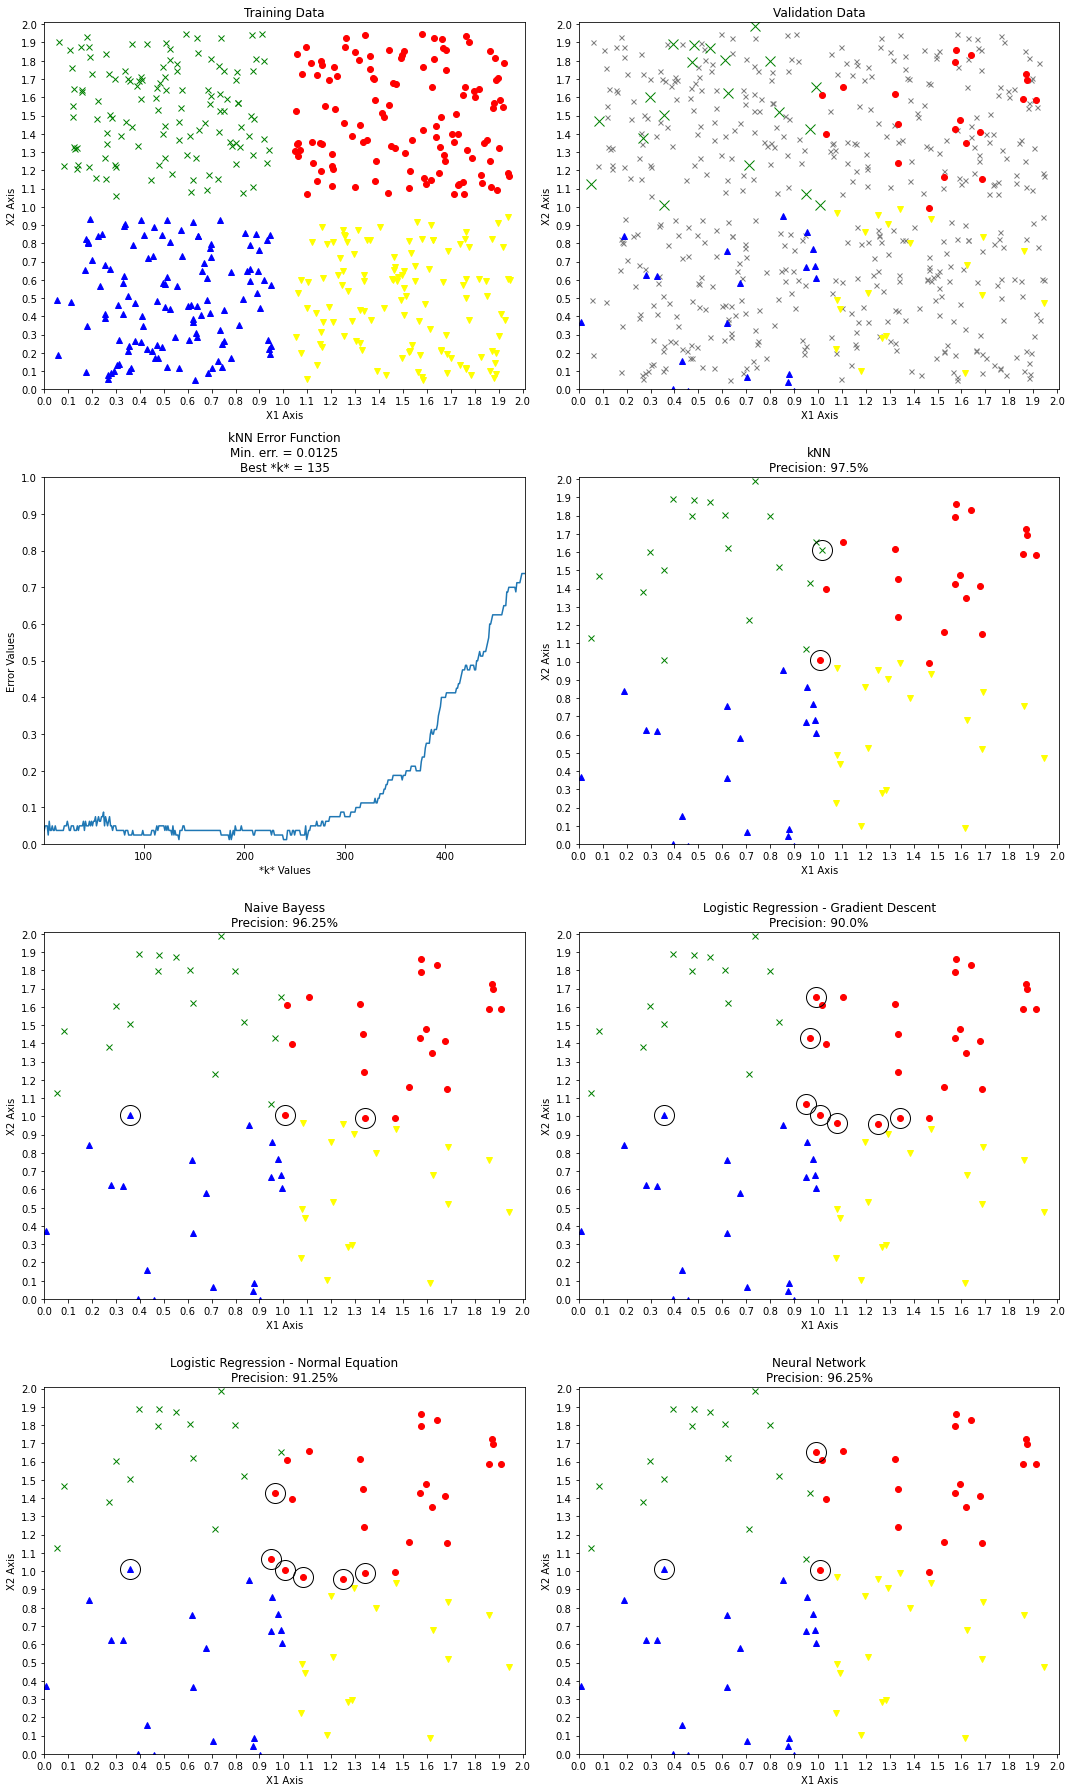

In [16]:
N_v = 20
N_t = 120
training_data = standard_data_generator(N_t, 0.45)
validation_data = standard_data_generator(N_v, 0.51)
fig = plt.figure(figsize=(15, 25))
plot_training_data_only(training_data, 1, N_t)
plot_validation_data(training_data, validation_data, 2, N_t, N_v)
plot_knn(training_data, validation_data, 3)
plot_naive_bayess(training_data, validation_data, 5)
plot_logistic_regression(training_data, validation_data, 6)
plot_neural_network(training_data, validation_data, 8)
plt.tight_layout()
plt.draw()